JAX [@jax2018github] implementation of the score-driven model featuring location, scale and shape common factors introduced in Labonne P. (2024). "Asymmetric uncertainty: Nowcasting using skewness in real-time data". *International Journal of Forecasting*

JAX adds automatic differentiation and high-performance numerical computing features to code written in Python.

#### First install all necessary python libraries

In [26]:
%%capture

! pip install -r requirements.txt

#### R code for building a dataframe from fred-md vintages. The dataframe is saved in the `arrow` `parquet` format for easy interoperability with Python.

In [27]:
%%capture

# first install all necessary packages
! Rscript "R/install.R"

# build the dataframe
! Rscript "R/fredmd.R"

#### Load the dataframe in `Python`

In [28]:
import pyarrow.parquet as pq

# load the data
df = pq.read_table("data/df_fredmd.parquet").to_pandas()

df

,date,INDPRO,CE16OV,CUMFNS,DPCERA3M086SBEA,PAYEMS,RETAILx,RPI,UNRATE
0,1959.083333,1.738279,-0.612898,1.481509,0.966960,0.438704,0.169163,0.110199,-0.224538
1,1959.166667,1.230835,1.193374,1.230779,0.848629,0.808025,0.234181,0.329129,-0.686613
2,1959.250000,1.906412,0.990503,1.801505,-0.782696,0.741097,-0.261192,0.333689,-0.917651
3,1959.333333,1.295589,-0.339024,1.099839,1.179025,0.488271,0.200892,0.273098,-0.224538
4,1959.416667,-0.082853,0.170076,-0.170418,0.126977,0.175401,0.281956,0.041557,-0.224538
...,...,...,...,...,...,...,...,...,...
777,2023.833333,0.162480,0.367459,0.363541,0.189933,-0.042583,-0.233764,0.113831,-0.224538
778,2023.916667,-0.510677,-0.815139,-0.086090,0.244151,0.073831,-0.067334,-0.044320,0.006500
779,2024.000000,-0.981633,-0.207511,-1.174170,-0.724201,0.036609,-1.001622,0.295708,0.006500
780,2024.083333,0.242271,-0.350544,0.961427,0.273061,0.051226,0.350324,-0.271700,0.468575


#### Estimation with maximum likelihood

In [29]:
import sys
sys.path.append('src') # to find sdfm
from sdfm import build_model
from sdfm import mle

import jax
import jax.numpy as jnp
from jax import random

# convert the data to a JAX type
df_np = df.to_numpy() # for easy use with JAX
y = jnp.array(df_np[:, 1:])

# build the model
slack_model = build_model(y)

# estimation with maximum likelihood
key = jax.random.PRNGKey(123)
mle_result = mle(model=slack_model, iter=50, pertu=0.25, key=key)

print("ML at", -mle_result.fun)

ML at -4198.79052734375


#### Run the filter with the estimated parameters

In [30]:
from sdfm import sd_filter
estimated_filter = sd_filter(mle_result.x, slack_model)

#### Plot of the estimated common factors

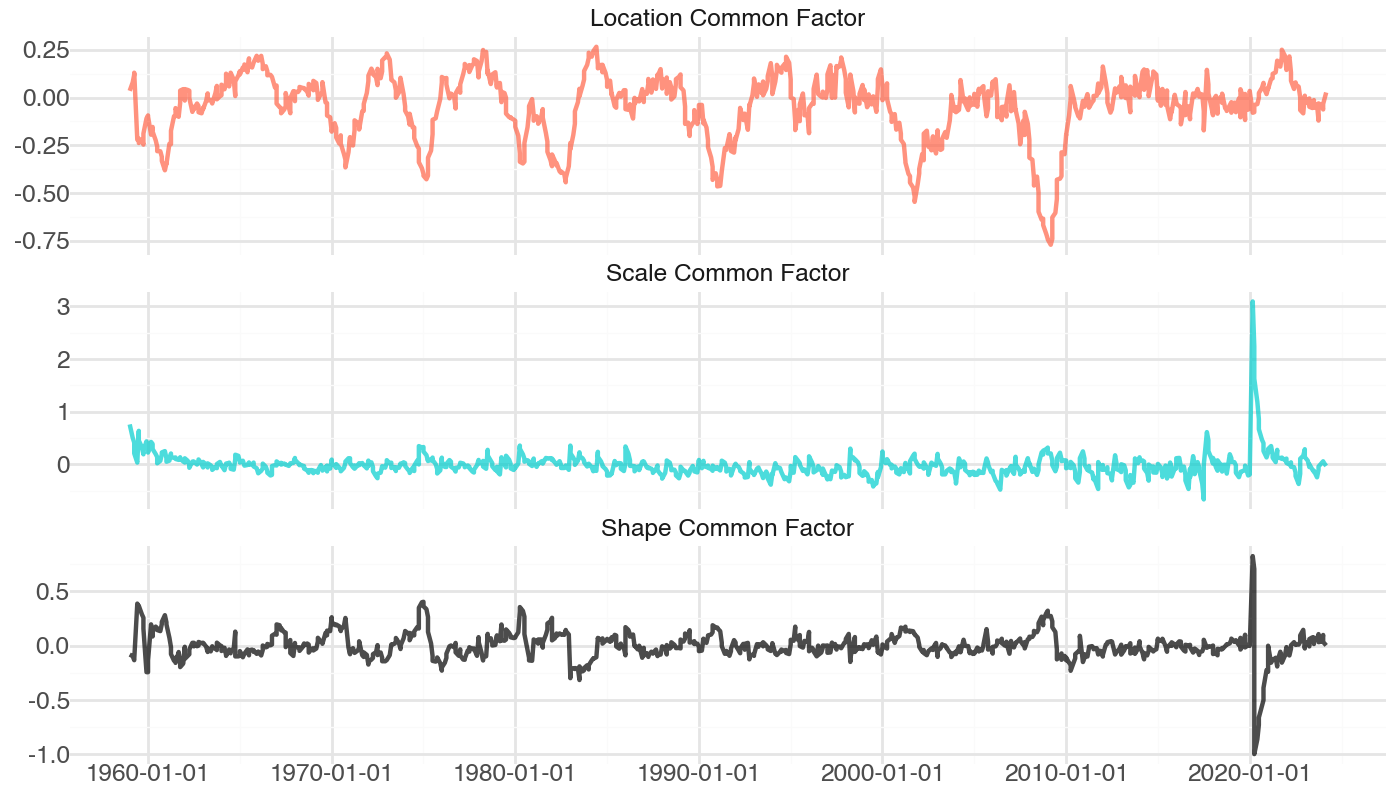

In [31]:
#| echo: false
import pandas as pd

from plotnine import (
    ggplot,
    aes,
    geom_line,
    labs,
    theme_minimal,
    facet_wrap,
    theme,
    scale_x_datetime,
    scale_color_manual,
)


# first deal with the dates
# Function to convert yearmon from numeric format
def convert_yearmon(yearmon):
    year = int(yearmon)
    month = int((yearmon - year) * 12 + 1)  # Adjusting for base-1 index
    return pd.Timestamp(year=year, month=month, day=1)


# Apply the conversion function
dates = pd.to_numeric(df["date"])
dates = dates.apply(convert_yearmon)

# create dataframe for plotting
df_plot = pd.DataFrame(
    {
        "date": dates,
        "Location Common Factor": estimated_filter[0][0, :, y.shape[1]],
        "Scale Common Factor": estimated_filter[0][1, :, y.shape[1]],
        "Shape Common Factor": estimated_filter[0][2, :, y.shape[1]],
    }
)

df_plot = df_plot.melt("date", var_name="variable", value_name="value")

# Plotting
plot = (
    ggplot(df_plot, aes(x="date", y="value", color="variable"))
    + geom_line(alpha=0.7, size = 0.9)
    + labs(title="", x="", y="")
    + theme_minimal()
    + theme(figure_size=(7, 4), legend_position="none")
    + scale_x_datetime(date_breaks="10 years")
    + scale_color_manual(values=["tomato", "#00CDCD", "black"])  # Custom colors
    + facet_wrap("~variable", scales="free_y", nrow=3)
)

# Display the plot
plot.show()